In [1]:
# import libraries ต่าง ๆ ที่จะใช้
import torchviz
import torch
import os
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # ใช้ในการแบ่งข้อมูล
import torch.nn as nn
import numpy as np

from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from torchmetrics.classification import MulticlassPrecisionRecallCurve
from torch.utils.data import WeightedRandomSampler
import optuna
from optuna.trial import TrialState
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
from optuna.integration.tensorboard import TensorBoardCallback
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

In [2]:
# import dataset
df = pd.read_csv("../3 - Cleaning & Transforming Data/2 cleaned_dataset_MERGED_DRUG(Mogran)_ALLELESEQ.csv", index_col = None)
# assign stratify
df_stratify = pd.DataFrame()
df['ADR'] = df['ADR'].replace({'SJS': 0, 'TEN': 1, 'MPexanthema':2,'MPeruption':3})
df_stratify['ADR'] = df['ADR'].copy()
# drop unnessary columns
df.drop(columns=['No_ADR','ADR','ADR_MPeruption','ADR_MPexanthema','ADR_SJS','ADR_TEN','Cohort ethnicity','Allele','Drug'], inplace=True)

if(df.isna().any().sum()) != 0:
    raise Exception('There are still missing values in the dataset!')

df_stratify['ADR'].value_counts()
print(df.dtypes)

# Select output columns and drop unnecessary columns
df_output = df['Yes_ADR'].copy()
df.drop(columns = ['Yes_ADR'], inplace = True)
df_input = df.copy()
# Check input dtypes
df_input.dtypes.value_counts()

# Convert to numpy array
np_input = df_input.to_numpy()
np_output = df_output.to_numpy()
np_stratify = df_stratify.to_numpy()

print(np_input)

def get_dataloaders(batch_size):

    # Train Test Splits
    X_train, X_test, y_train, y_test = train_test_split(np_input, np_output, test_size = 0.2, random_state = 128, stratify = np_stratify, shuffle = True)

    # See Distribution
    print('BEFORE applying weight train_label data distribution 0/1: {}/{}'.format(
    len(np.where(y_train == 0)[0]), len(np.where(y_train == 1)[0])))

    print('BEFORE applying weight test_labels data distribution 0/1: {}/{}'.format(
    len(np.where(y_test == 0)[0]), len(np.where(y_test == 1)[0])))

    # Find Weight of each class in train_labels
    weight = (1/pd.DataFrame(y_train).value_counts()).tolist()
    sample_weights = np.array([weight[int(t)] for t in y_train])

    # Create Sampler
    sampler = WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights), replacement=True)

    # Create TensorDataset
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=y_test.shape[0])

    return train_loader, test_loader

# Function to check dataloader classes distribution
def get_dataloader_distribution(*args):
    graph_no = len(args)
    fig, ax = plt.subplots(graph_no,1)
    
    for index, dataloader in enumerate(args):
        batch_no = [x+1 for x in range(len(dataloader))]
        class_0_count = []
        class_1_count = []
        batch_count = []

        for i, (data,target) in enumerate(dataloader):
            tocount = pd.DataFrame(target.numpy()).value_counts()
            batch_count.append(i+1)
            class_0_count.append(tocount[0.0])
            class_1_count.append(tocount[1.0])

        X_axis = np.arange(len(batch_count))

        
        fig.set_figwidth(15)
        fig.set_figheight(10)
        ax[index].set_xlabel="Batch Number"
        ax[index].set_ylabel="No. Datapoints"
        ax[index].bar(X_axis,class_0_count,width=(1/3) ,label = "NoADR",color='green',alpha=0.5)
        ax[index].bar(X_axis+(1/3),class_1_count,width=(1/3), label = 'ADR',color='red',alpha=0.5)
        #ax.set_xticks(X_axis+width)
        ax[index].legend()

        ax[index].set_title(f"{dataloader} Data Distribution")
    fig.show()

Cohort ethnicity_Black          int64
Cohort ethnicity_Caucasian      int64
Cohort ethnicity_Diverse        int64
Cohort ethnicity_Mongol         int64
Yes_ADR                       float64
                               ...   
p2-54-S                         int64
p2-54-T                         int64
p2-54-V                         int64
p2-54-W                         int64
p2-54-Y                         int64
Length: 4364, dtype: object
[[0 0 1 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


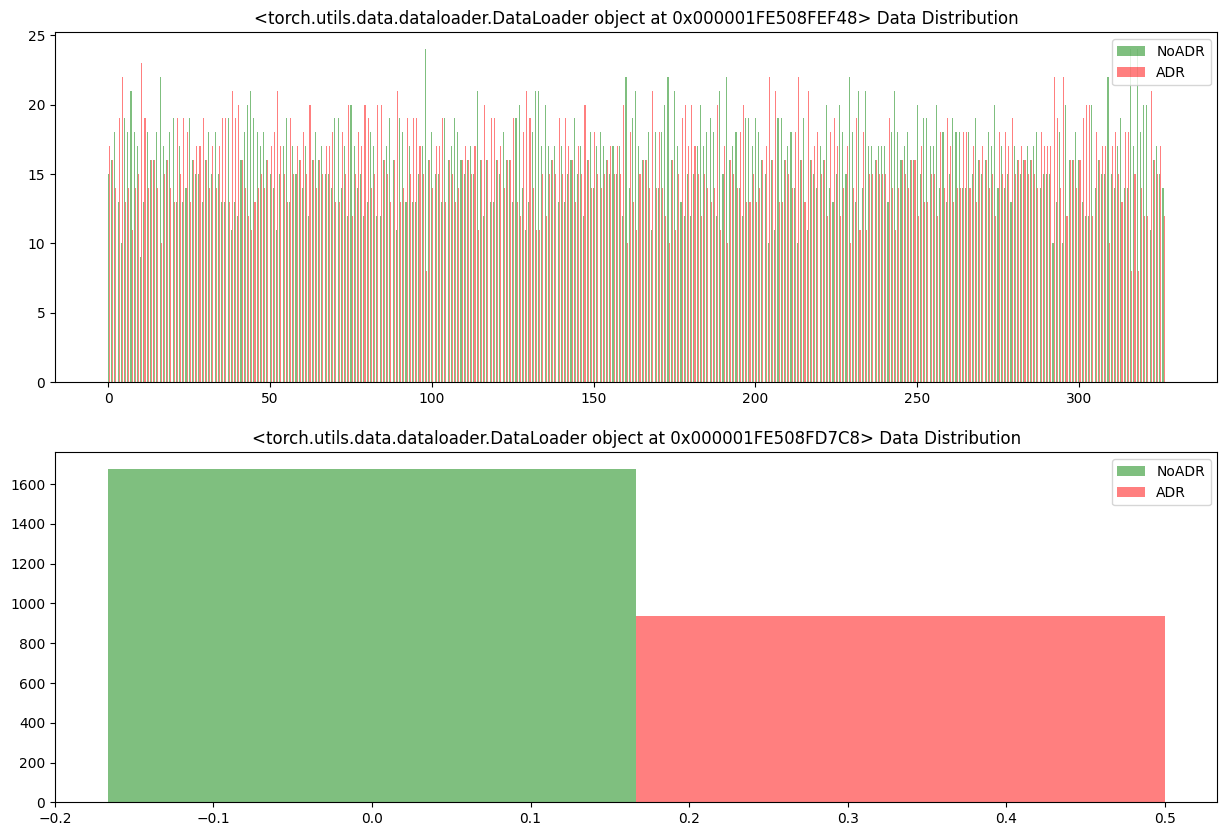

In [3]:
# Define the model hyperparameters
classes = 1
batch_size = 32 
LEARNING_RATE = 2e-5 
DROPOUT_RATE = 0.2
L2lambda = 1e-2
EPOCHS = 1000
DIR = os.getcwd()
dirname = "optuna_study1" 
train_loader, test_loader = get_dataloaders(batch_size)
loss_fn = nn.BCELoss() 
get_dataloader_distribution(train_loader,test_loader)

In [16]:
model = nn.Sequential(
    nn.Linear(10, 64),
)


In [23]:
model = torch.jit.script(model)
model.save('model_test.pt')
model

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
)

In [22]:
model2 = torch.jit.load('model_test.pt')
model2.eval()
model2

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
)